In [3]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Conv2D, MaxPooling2D, Flatten,Activation,BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB0

from tensorflow.keras import callbacks as cb
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)

from functools import partial
from tqdm.auto import tqdm

In [4]:
# https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
def decode_img(img):
  img = tf.image.decode_jpeg(img , channels=3)
  return img

def process_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, file_path

list_style_images_ds = tf.data.Dataset.list_files(str('styles/*.jpg'), shuffle=False)

In [5]:
len(list_style_images_ds)

100

In [26]:
N, M = 400, 400
cached_style_ds = (list_style_images_ds
   .map(process_path)
   .filter(lambda *args: tf.shape(args[0])[0] >= N)
   .filter(lambda *args: tf.shape(args[0])[1] >= M)
).cache()

Cause: could not parse the source code:

   .filter(lambda *args: tf.shape(args[0])[0] >= N)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

   .filter(lambda *args: tf.shape(args[0])[0] >= N)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

   .filter(lambda *args: tf.shape(args[0])[1] >= M)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

   .filter(lambda *args: tf.shape(args[0])[1] >= M)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate 

In [27]:
# preload 
for _ in tqdm(cached_style_ds):
  pass

In [28]:
def crop_n_clips_with_size(img, n=None, size=(None, None)):
  if len(size) == 2:
    size = (*size, 3)
  return (
    tf.stack(
      [tf.image.random_crop(img, size) for _ in range(n)],
      axis=0
    )
  )

In [29]:
WAYS = 3
SHOTS = 5
QUERIES = 1
BATCH_SIZE = 4

CROPSIZE = (224, 224)
crop_SHOTS_clips_with_CROPSIZE = partial(crop_n_clips_with_size, n=SHOTS, size=CROPSIZE)
crop_1_clips_with_CROPSIZE = partial(crop_n_clips_with_size, n=1, size=CROPSIZE)

In [30]:
def sample_n_take_m_with_postprocess_fun1_fun2_gen(ds, n=None, m=None, fun1=None, fun2=None):
  ret_array = []
  for args in ds:
    ret_array.append(args)
    if len(ret_array) < n:
      continue
    
    n_imgs, *meta_args = zip(*ret_array)
    
    taked_m_idx = tf.random.uniform(
      [m],
      maxval=n,
      dtype=tf.dtypes.int32,
    )
    
    taked_m_imgs = [n_imgs[idx] for idx in taked_m_idx]
    
    post_n_imgs = tf.concat([*map(fun1, n_imgs)], axis=0)
    post_taked_m_imgs = tf.concat([*map(fun2, taked_m_imgs)], axis=0)
    
    label = tf.one_hot(taked_m_idx,depth=n, dtype=tf.float32)
    
    yield (
      (
        tf.cast(tf.concat([post_n_imgs, post_taked_m_imgs], axis=0), tf.float32),
        *label
      )#,
#       *meta_args
    )
    
    ret_array = []

In [31]:
final_ds = tf.data.Dataset.from_generator(
  partial(
    sample_n_take_m_with_postprocess_fun1_fun2_gen,
    ds=cached_style_ds.shuffle(
      buffer_size=9999,
      seed=228922,
      reshuffle_each_iteration=True,
    ),
    n=WAYS, m=QUERIES,
    fun1=crop_SHOTS_clips_with_CROPSIZE,
    fun2=crop_1_clips_with_CROPSIZE
  ),
  output_types=(tf.float32, tf.float32),
  output_shapes=((WAYS*SHOTS+QUERIES,*CROPSIZE,3), (WAYS,)*QUERIES)
).batch(BATCH_SIZE, drop_remainder=True)

final_ds

<BatchDataset shapes: ((4, 16, 224, 224, 3), (4, 3)), types: (tf.float32, tf.float32)>

In [32]:
def conv_net(input_shape):
    convnet = Sequential()
    for i in range(4):
        convnet.add(Conv2D(64,(3,3),padding='valid',input_shape=input_shape))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    return convnet
def pretrain_net(input_shape):
    base_model = EfficientNetB0(weights="imagenet", include_top=False)
    x_in=Input(shape=(W,H,CH))
    x=preprocess_input(x_in)
    out=Flatten()(base_model(x))
    model = Model(inputs=x_in, outputs=out)
    return model
def euclidean_distance(f_1,f_2):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(f_1 - f_2), axis=-1))

In [33]:
W,H,CH = *CROPSIZE,3
base_dim = (W,H,CH)
base_network = pretrain_net(base_dim)
# Query feature
x_in=Input(shape=(WAYS*SHOTS+QUERIES,W,H,CH))
latent_s=[base_network(x_in[:,ii]) for ii in range(WAYS*SHOTS)]
latent_q=[base_network(x_in[:,WAYS*SHOTS+ii]) for ii in range(QUERIES)]

y=list()
for qq in range(QUERIES):
    dist_scores=list()
    for ww in range(WAYS):
        latent_proto=tf.reduce_mean(tf.stack(latent_s[ww*SHOTS:(ww+1)*SHOTS],axis=-1),axis=-1)
        dist_avg=euclidean_distance(latent_q[qq],latent_proto)
        dist_scores.append(dist_avg)
    y.append(tf.nn.softmax(-tf.stack(dist_scores,axis=-1),axis=-1))

model = Model(inputs=x_in, outputs=tuple(y))

In [34]:
lr=0.001
def scheduler(epoch):
    global lr
    if epoch % 3 == 0:
        lr /= 2
    return lr
reduce_lr = cb.ReduceLROnPlateau(monitor='loss', factor=0.4,patience=2, min_lr=1e-8)
lr_sched = cb.LearningRateScheduler(scheduler)
tensorboard = cb.TensorBoard()
opt = tf.keras.optimizers.Adam(lr=0.002)
model.compile(loss=CategoricalCrossentropy(), optimizer=opt, metrics=['categorical_accuracy'])

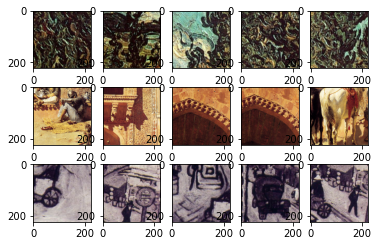

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>

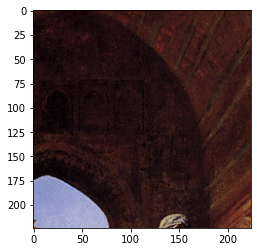

In [39]:
TRAIN_ARRAY = [*iter(final_ds)]

X,Y = zip(*TRAIN_ARRAY)

for idx in range(15):
  plt.subplot(3,5,idx+1)
  plt.imshow(X[0][0][idx]/255)
plt.show()
plt.imshow(X[0][0][-1]/255)
Y[0][0]